In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Capstone/capstone_raw_data_v2.0') 

Mounted at /content/gdrive


In [ ]:
#data.py
import pandas as pd

def read_action_data(action, files):
  data_list = []
  
  file_name = action + "_%d.csv"
  for i in range(files):
    df = pd.read_csv ((file_name%i), names=["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ"])
    data_list.append(df)
  consolidated = pd.concat(data_list)
  consolidated['Action']=action
  return consolidated
  
def raw_to_df(files):
  grenade = read_action_data('grenade', files)
  shield = read_action_data('shield', files)
  quit =  read_action_data('quit', files)
  reload = read_action_data('reload', files)
  walk = read_action_data('walk', files)
  consolidated = pd.concat([grenade,shield,quit,reload])
  con_w = pd.concat([grenade,shield,quit,reload,walk])
  return (grenade,shield,quit,reload,walk,consolidated,con_w)


In [ ]:
#data_analysis.py
import numpy as np
import pandas as pd


#Data Analysis for activity detection
def plot_columns(column_name,grenade,shield,quit,reload,walk):
  grenade[[column_name]].plot()
  shield[[column_name]].plot()
  quit[[column_name]].plot()
  reload[[column_name]].plot()
  walk[[column_name]].plot()

#Double check activity detection threshold
def sample_splitter(data):
  samples = []
  for i in range(int(len(data)/60)):
    temp = data[i*60:(i*60+60)]
    samples.append(temp)
  return samples

#y of non action seems to always be negative
def activity_checker(sample):
  a_level = 0
  for z in range(len(sample)):
    if sample[z]> 0.5:
      a_level+=1
    if sample[z]> 0:
      a_level+=1
    if sample[z]>-0.2:
      a_level+=1


  return a_level


def max_act_checker(samples):
  highest = -100
  for t in range(len(samples)):
    sample = samples[t]
    c_act = activity_checker(sample)
    if highest == -100:
      highest = c_act
    elif c_act > highest:
      highest = c_act
  return str(highest)

def min_act_checker(samples):
  lowest = 100
  for t in range(len(samples)):
    sample = samples[t]
    c_act = activity_checker(sample)
    if lowest == 100:
      lowest = c_act
    elif c_act < lowest:
      lowest = c_act
  return str(lowest)

def column_values(data, column_name):
  return data[[column_name]].values

def act_range_checker(data):
  arr = column_values(data, 'AccX')
  samples = sample_splitter(arr)
  min = min_act_checker(samples)
  max = max_act_checker(samples)
  return " Min: %s, Max: %s"%(min, max)


def get_corr(extracted, labels, threshold):
  test = pd.DataFrame(np.array(extracted))
  labels_test = pd.DataFrame(np.array(labels))
  labels_test.columns = ["Action"]
  corr = pd.concat([test,labels_test], axis=1)
  corr['Action'] = pd.Categorical(corr['Action'])
  corr['action'] = corr['Action'].cat.codes
  action_corr = corr.corr().iloc[432].to_numpy()

  columns = []
  acc_x = True
  acc_y = True
  acc_z = True
  g_x = True
  g_y = True
  g_z = True
  mag = True
  for i in range(len(action_corr)):
    if action_corr[i] >=threshold or action_corr[i] <= -threshold:
      if i <60 and acc_x:
        print("accx: %s"%action_corr[i])
        acc_x = False
        columns.append(i+1)
      elif i >=60 and i <120 and acc_y:
        print("accy: %s"%action_corr[i])
        acc_y = False
        columns.append(i+1)
      elif i >=120 and i <180 and acc_z:
        print("accz: %s"%action_corr[i])
        acc_z = False
        columns.append(i+1)
      elif i >=180 and i <240 and g_x:
        print("gyrox: %s"%action_corr[i])
        g_x = False
        columns.append(i+1)
      elif i >=240 and i <300 and g_y:
        print("gyroy: %s"%action_corr[i])
        g_y = False
        columns.append(i+1)
      elif i >=300 and i <360 and g_z:
        print("gyroz: %s"%action_corr[i])
        g_z = False
        columns.append(i+1)
      elif i >=360 and i <372:
        columns.append(i+1)
        if(i== 360):
          print("acc mean x: %s"%(action_corr[i]))
        if(i == 361):
          print("acc mean y: %s"%action_corr[i])
        if(i == 362):
          print("acc mean z: %s"%action_corr[i])
        if(i == 363):
          print("gyro mean x: %s"%action_corr[i])
        if(i == 364):
          print("gyro mean y: %s"%(action_corr[i]))
        if(i== 365):
          print("gyro mean z: %s"%action_corr[i])
        if(i == 366):
          print("acc median x: %s"%action_corr[i])
        if(i == 367):
          print("acc median y: %s"%action_corr[i])
        if(i == 368):
          print("acc median z: %s"%action_corr[i])
        if(i == 369):
          print("gyro median x: %s"%action_corr[i])
        if(i == 370):
          print("gyro median y: %s"%action_corr[i])
        if(i== 371):
          print("gyro median z: %s"%action_corr[i]) 
      elif i >=372 and i < 432 and mag:
        mag = False
        columns.append(i+1)
        print("mag: %s"%action_corr[i])



In [ ]:
#feature.py
from numpy import mean, median
import numpy as np
from scipy import stats

def split_samples(combined_raw, timesteps):
  segments = []
  labels = []
  N_TIME_STEPS = timesteps
  for i in range(0, len(combined_raw) - N_TIME_STEPS):
    ax = combined_raw['AccX'].values[i: i + N_TIME_STEPS]
    ay = combined_raw['AccY'].values[i: i + N_TIME_STEPS]
    az = combined_raw['AccZ'].values[i: i + N_TIME_STEPS]
    gx = combined_raw['GyroX'].values[i: i + N_TIME_STEPS]
    gy = combined_raw['GyroY'].values[i: i + N_TIME_STEPS]
    gz = combined_raw['GyroZ'].values[i: i + N_TIME_STEPS]
    label = stats.mode(combined_raw['Action'][i: i + N_TIME_STEPS])[0][0]
    segments.append([ax, ay, az, gx, gy, gz])
    labels.append(label)
  return (segments, labels)

def split_samples_2s(combined_raw):
  segments = []
  labels = []
  N_TIME_STEPS = 40
  for i in range(0, len(combined_raw) - 60):
    if i%60 >= 40:
      pass
    else:
      ax = combined_raw['AccX'].values[i: i + N_TIME_STEPS]
      ay = combined_raw['AccY'].values[i: i + N_TIME_STEPS]
      az = combined_raw['AccZ'].values[i: i + N_TIME_STEPS]
      gx = combined_raw['GyroX'].values[i: i + N_TIME_STEPS]
      gy = combined_raw['GyroY'].values[i: i + N_TIME_STEPS]
      gz = combined_raw['GyroZ'].values[i: i + N_TIME_STEPS]
      label = stats.mode(combined_raw['Action'][i: i + N_TIME_STEPS])[0][0]
      segments.append([ax, ay, az, gx, gy, gz])
      labels.append(label)
  return (segments, labels)

def Mean(data):
    """Returns the mean of a time series"""
    return data.mean()

def Median(data):
    """Returns the median of a time series"""
    return data.median()


from math import sqrt

def extract_acc_magnitude(data):
  mag_array = []
  for i in range(len(data)):
    mags = []
    for t in range(len(data[i][0])): 
     mags.append( sqrt( data[i][0][t]**2 + data[i][1][t]**2 + data[i][2][t]**2) )
    mag_array.append(mags)
  return mag_array

def extract_acc_median(data):
  median_array = []

  for i in range(len(data)):
    median_array.append([np.median(data[i][0]), np.median(data[i][1]), np.median(data[i][2])])
  return median_array

def extract_gyro_median(data):
  median_array = []

  for i in range(len(data)):
    median_array.append([np.median(data[i][3]), np.median(data[i][4]), np.median(data[i][5])])
  return median_array


def extract_acc_mean(data):
  mean_array = []

  for i in range(len(data)):
    mean_array.append([Mean(data[i][0]),Mean(data[i][1]),Mean(data[i][2])])
  return mean_array

def extract_gyro_mean(data):
  mean_array = []

  for i in range(len(data)):
    mean_array.append([Mean(data[i][3]),Mean(data[i][4]),Mean(data[i][5])])
  return mean_array

#2-181 acc, 182-361 gyro, 362-364 mean_a, 365-367 mean_g, 368-370 median_a, 371-373 median_g, 374-433 mag_a 
#acc mean -0.205, 0.628, 0.331
#gyro mean -0.02446,-0.274, 0.18607
#acc median 0.395, 0.66567, 0.1941
#gyro median -0.24592, .086605, -0.01507
def merge_feature_array(raw, mean_a, mean_g, median_a, median_g, mag):
  out = []
  raw = np.array(raw)
  for i in range(len(raw)):
    arr1 = np.concatenate((raw[i].flatten(), mean_a[i]))
    arr2 = np.concatenate((arr1, mean_g[i]))
    arr3 = np.concatenate((arr2, median_a[i]))
    arr4 = np.concatenate((arr3, median_g[i]))
    arr5 = np.concatenate((arr4,mag[i]))
    out.append(arr5)

  return out



def merge_feature_array_reduced(raw, mean_a, mean_g, median_a, median_g):
  out = []
  raw = np.array(raw)
  for i in range(len(raw)):
    temp = raw[i][:3]
    arr1 = np.concatenate((temp.flatten(), mean_a[i]))
    arr2 = np.concatenate((arr1, mean_g[i]))
    arr3 = np.concatenate((arr2, median_a[i]))
    arr4 = np.concatenate((arr3, median_g[i]))
    out.append(arr4)

  return out



def extract_features(data):
  raw = data
  mean_a = extract_acc_mean(data)
  mean_g = extract_gyro_mean(data)
  median_a = extract_acc_median(data)
  median_g = extract_gyro_median(data)
  mag = extract_acc_magnitude(data)
  return merge_feature_array(raw,mean_a,mean_g,median_a,median_g, mag)

def label_index(labels, one_hot):
  def find_index(index):
    for i in range(len(one_hot)):
      if one_hot[i][index] == 1:
        return (labels[i], index, one_hot[i])
  for i in range(5):
    print("%s -  index: %s, one hot: %s"%(find_index(i)))

def generate_test(segments, one_hot):
  samples = []
  def find_index(index):
    for i in range(len(one_hot)):
      if one_hot[i][index] == 1:
        return segments[i]
  for i in range(4):
    samples.append(find_index(i))
  return samples

def save_test(segments, one_hot):
  samples = generate_test(segments, one_hot)
  test_inputs = "float test_input[INPUT_LAYER*NO_OF_TESTCASE] = " + bias_to_cpp(samples)
  file = open("test.txt", "w+")
  file.write(test_inputs)
  file.close()

In [ ]:
def extract_features_reduced(data):
  raw = data
  mean_a = extract_acc_mean(data)
  mean_g = extract_gyro_mean(data)
  median_a = extract_acc_median(data)
  median_g = extract_gyro_median(data)
  return merge_feature_array_reduced(raw,mean_a,mean_g,median_a,median_g)

In [ ]:
#model.py
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import adam_v2

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

def prepare_training_data(segments, labels):
  extracted = extract_features(segments)
  one_hot = np.asarray(pd.get_dummies(labels), dtype = np.float32)
  return (extracted, one_hot)


def prepare_training_data_reduced(segments, labels):
  extracted = extract_features_reduced(segments)
  one_hot = np.asarray(pd.get_dummies(labels), dtype = np.float32)
  return (extracted, one_hot)

def model_eval(model, X_test, y_test):
  loss, acc = model.evaluate(x=X_test, y=y_test)
  y_prediction = model.predict(X_test)
  print("Test accuracy: %3.2f, loss: %3.2f"%(acc, loss))

  y_pred=np.argmax(y_prediction, axis=1)
  y_test=np.argmax(y_test, axis=1)
  cm = confusion_matrix(y_test, y_pred)

  df_cm = pd.DataFrame(cm, range(5), range(5))
  plt.figure(figsize=(10,7))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

  plt.show()

  np.savetxt('x.csv', X_test, delimiter=',')
  np.savetxt('y.csv', y_test, delimiter=',')



def np_to_cpp(data):
  layer = np.transpose(np.array(data))
  layer_flat = layer.flatten()
  layer_cpp = '{'
  for i in range(len(layer_flat)):
    layer_cpp += str(layer_flat[i])
    if i < len(layer_flat)-1:
      layer_cpp +=','
  layer_cpp +='};'
  return layer_cpp

def bias_to_cpp(data):
  layer = np.array(data)
  layer_flat = layer.flatten()
  layer_cpp = '{'
  for i in range(len(layer_flat)):
    layer_cpp += str(layer_flat[i])
    if i < len(layer_flat)-1:
      layer_cpp +=','
  layer_cpp +='};'
  return layer_cpp


def model_to_cpp(model):
  layer_1_cpp = np_to_cpp(model.layers[0].get_weights()[0])
  layer_1_bias = bias_to_cpp(model.layers[0].get_weights()[1])
  layer_2_cpp = np_to_cpp(model.layers[1].get_weights()[0])
  layer_2_bias = bias_to_cpp(model.layers[1].get_weights()[1])
  layer_3_cpp = np_to_cpp(model.layers[2].get_weights()[0])
  layer_3_bias = bias_to_cpp(model.layers[2].get_weights()[1])
  w_1 = "float l1_weight[INPUT_LAYER * LAYER_1] = " + layer_1_cpp
  w_2 = "float l2_weight[LAYER_1 * LAYER_2] = " + layer_2_cpp
  w_3 = "float output_weight[LAYER_2 * OUTPUT_LAYER] = " + layer_3_cpp
  b_1 = "float l1_bias[LAYER_1] = " + layer_1_bias
  b_2 = "float l2_bias[LAYER_2] = " + layer_2_bias
  b_3 = "float output_bias[OUTPUT_LAYER] = " + layer_3_bias

  file = open("cpp_weights.txt", "a+")
  file.write(w_1)
  file.write("\n")
  file.write("\n")
  file.write(w_2)
  file.write("\n")
  file.write("\n")
  file.write(w_3)
  file.write("\n")
  file.write("\n")
  file.write(b_1)
  file.write("\n")
  file.write("\n")
  file.write(b_2)
  file.write("\n")
  file.write("\n")
  file.write(b_3)

  

In [ ]:
grenade,shield,quit,reload,walk,combined_raw, con_w = raw_to_df(8)
print("Total number of samples : " + str(int(len(combined_raw)/60)))

Total number of samples : 1593


In [ ]:
segments2,labels2 = split_samples_2s(con_w)

In [ ]:
len(segments2)

71760

In [ ]:
np.array(segments2).shape

(71760, 6, 40)

In [ ]:
extracted_reduced, one_hot = prepare_training_data_reduced(segments, labels)


NameError: ignored

In [ ]:
np.array(extracted_reduced).shape

(71760, 132)

In [ ]:
test = sample_splitter(column_values(reload,'AccX'))
len(test)

188

In [ ]:
for i in range(len(test)):
  print(activity_checker(test[i]))

In [ ]:
#Take every 3rd reading 1 reading every 0.15s, 6.666 Hz
edit  = con_w.iloc[::3, :]
segments,labels = split_samples(edit, 20)
extracted_reduced, one_hot = prepare_training_data_reduced(segments, labels)
test = pd.DataFrame(np.array(extracted_reduced))

In [ ]:
grenade.head()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Action
0,-0.952881,-0.035156,-0.002930,-2.348397,-2.511450,2.790000,grenade
1,-0.953125,-0.045898,-0.015381,-0.630840,-2.793893,1.759466,grenade
2,-0.955078,-0.044434,-0.007568,-3.600306,-1.580153,1.370153,grenade
3,-0.959473,-0.046143,-0.010010,-1.562137,-2.641221,1.095344,grenade
4,-0.956787,-0.052979,-0.002930,-2.333130,-2.549618,0.148779,grenade


In [ ]:
plot_columns('AccZ',grenade,shield,quit,reload,walk)

In [ ]:
plot_columns('AccY',grenade,shield,quit,reload,walk)

In [ ]:
plot_columns('AccX',grenade,shield,quit,reload,walk)

In [ ]:
walk.head()


,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Action
0,-0.939453,-0.187012,-0.102051,-87.249161,11.572519,-28.156565,walk
1,-0.942383,-0.180908,-0.063965,-32.081219,12.603053,-27.439007,walk
2,-0.929199,-0.218262,-0.025635,24.056183,10.061069,-18.133663,walk
3,-0.935547,-0.212891,-0.016113,35.254658,11.213740,-28.118397,walk
4,-0.988770,-0.157959,-0.040283,12.880611,8.183207,-32.584045,walk


In [ ]:
print("Grenade - " + act_range_checker(grenade))
print("Quit - " + act_range_checker(quit))
print("Reload - " + act_range_checker(reload))
print("Shield - " + act_range_checker(shield))
print("Walk - " + act_range_checker(walk))

Grenade -  Min: 0, Max: 86
Quit -  Min: 52, Max: 132
Reload -  Min: 0, Max: 87
Shield -  Min: 28, Max: 140
Walk -  Min: 0, Max: 12


In [ ]:
test = column_values(shield, 'AccX')
temp = 0
for i in range(len(test)):
  if test[i]>-0.5:
    temp +=1
print(temp)

1659


In [ ]:
segments,labels = split_samples(combined_raw, 60)
extracted, one_hot = prepare_training_data(segments, labels)

In [ ]:
segments,labels = split_samples(con_w, 60)
extracted, one_hot = prepare_training_data(segments, labels)

In [ ]:
len(segments)

107636

In [ ]:
extracted_reduced, one_hot = prepare_training_data_reduced(segments, labels)

In [ ]:
#segments,labels = split_samples(combined_raw)
#extracted, one_hot = prepare_training_data(segments, labels)

RANDOM_SEED = 13
input_size = len(extracted[0])

X_train, X_test, y_train, y_test = train_test_split(
        np.array(extracted), one_hot, test_size=0.2, random_state=RANDOM_SEED)

model_m = Sequential()
model_m.add(Dense(32, input_shape = (input_size, ), activation = 'relu'))
model_m.add(Dense(64, activation='relu'))
model_m.add(Dense(5, activation='softmax'))



model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                13856     
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 16,293
Trainable params: 16,293
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print(input_size)

432


In [ ]:
history = model_m.fit(X_train,
                    y_train,
                      batch_size= 128,
                      epochs=50,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
539/539 [==============================] - 2s 3ms/step - loss: 10383162.0000 - accuracy: 0.7026 - val_loss: 242580.1406 - val_accuracy: 0.7809
Epoch 2/50
539/539 [==============================] - 1s 2ms/step - loss: 214226.4062 - accuracy: 0.8317 - val_loss: 1375189.7500 - val_accuracy: 0.8656
Epoch 3/50
539/539 [==============================] - 1s 2ms/step - loss: 179595.9688 - accuracy: 0.8910 - val_loss: 0.3705 - val_accuracy: 0.9383
Epoch 4/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2691 - accuracy: 0.9535 - val_loss: 0.2826 - val_accuracy: 0.9541
Epoch 5/50
539/539 [==============================] - 1s 2ms/step - loss: 0.1872 - accuracy: 0.9666 - val_loss: 0.2006 - val_accuracy: 0.9692
Epoch 6/50
539/539 [==============================] - 1s 2ms/step - loss: 428.1486 - accuracy: 0.9412 - val_loss: 0.2925 - val_accuracy: 0.9542
Epoch 7/50
539/539 [==============================] - 1s 2ms/step - loss: 0.1955 - accuracy: 0.9635 - val_loss: 0.2109

673/673 [==============================] - 1s 1ms/step
Test accuracy: 0.98, loss: 0.09


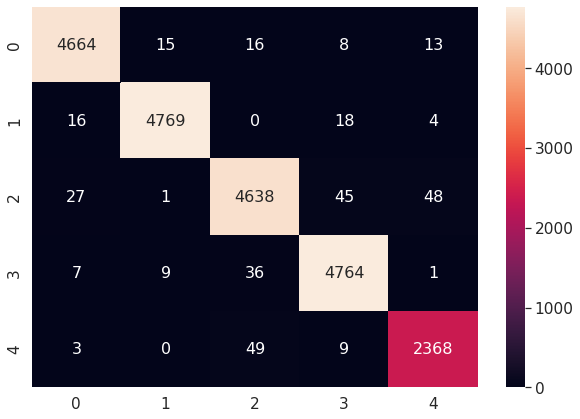

In [ ]:
model_eval(model_m, X_test, y_test)

In [ ]:
RANDOM_SEED = 13
input_size2 = len(extracted_reduced[0])//192

X_train2, X_test2, y_train2, y_test2 = train_test_split(
        np.array(extracted_reduced), one_hot, test_size=0.2, random_state=RANDOM_SEED)

model_m2 = Sequential()
model_m2.add(Dense(32, input_shape = (input_size2, ), activation = 'relu'))
model_m2.add(Dense(64, activation='relu'))
model_m2.add(Dense(5, activation='softmax'))



model_m2.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
print(model_m2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                6176      
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 8,613
Trainable params: 8,613
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print(input_size2)

132


In [ ]:
history = model_m2.fit(X_train2,
                    y_train2,
                      batch_size= 128,
                      epochs=50,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
539/539 [==============================] - 1s 2ms/step - loss: 5119621.0000 - accuracy: 0.9270 - val_loss: 0.1065 - val_accuracy: 0.9713
Epoch 2/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0843 - accuracy: 0.9778 - val_loss: 0.0734 - val_accuracy: 0.9811
Epoch 3/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0589 - accuracy: 0.9845 - val_loss: 0.0541 - val_accuracy: 0.9856
Epoch 4/50
539/539 [==============================] - 1s 2ms/step - loss: 106180.7734 - accuracy: 0.9875 - val_loss: 0.0482 - val_accuracy: 0.9873
Epoch 5/50
539/539 [==============================] - 1s 1ms/step - loss: 0.0345 - accuracy: 0.9904 - val_loss: 84342.2969 - val_accuracy: 0.9906
Epoch 6/50
539/539 [==============================] - 1s 1ms/step - loss: 106841.4141 - accuracy: 0.9880 - val_loss: 0.0341 - val_accuracy: 0.9904
Epoch 7/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0254 - accuracy: 0.9935 - val_loss: 0.0276 - val_acc

673/673 [==============================] - 1s 1ms/step
Test accuracy: 1.00, loss: 0.01


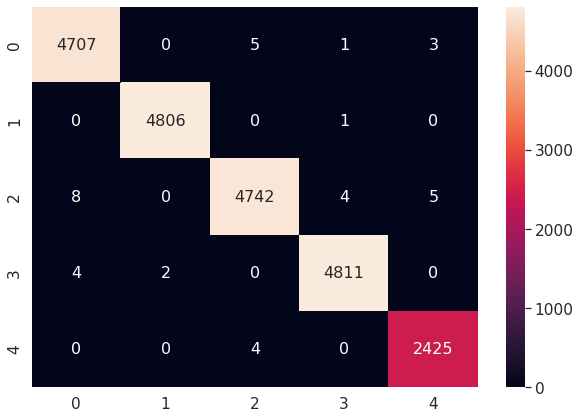

In [ ]:
model_eval(model_m2, X_test2, y_test2)

In [ ]:
get_corr(extracted,labels,0.2)

accy: -0.24711613772097707
accz: -0.24943301826623052
acc mean y: -0.4510444422625364
acc mean z: -0.3720804368203768
gyro mean x: 0.3934207807675322
acc median y: -0.3594014170200692
acc median z: -0.36534019802414275
gyro median x: 0.2993924760354565


In [ ]:
label_index(labels, one_hot)

grenade -  index: 0, one hot: [1. 0. 0. 0. 0.]
quit -  index: 1, one hot: [0. 1. 0. 0. 0.]
reload -  index: 2, one hot: [0. 0. 1. 0. 0.]
shield -  index: 3, one hot: [0. 0. 0. 1. 0.]
walk -  index: 4, one hot: [0. 0. 0. 0. 1.]


In [ ]:
model_m.save('actual_v2')

In [ ]:
model_to_cpp(model_m2)

In [ ]:

save_test(X_test,y_test)
